In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.llamma import LLAMMA
from src.controller import Controller
from src.oracle import Oracle
from src.mpolicy import MonetaryPolicy
from src.liquidator import Liquidator
import pandas as pd
import numpy as np
from datetime import datetime
from src.utils import _plot_borrowers, gen_gbm
import matplotlib.pyplot as plt
from src.utils import external_swap
import copy
import imageio

In [3]:
WINDOW = 600 # 10 minutes
BASE_PRICE = 1800
A = 100
# FEE = 0.006
FEE = 0
ADMIN_FEE = 1
LOAN_DISCOUNT = 0.09
LIQUIDATION_DISCOUNT = 0.06

N_BORROWERS = 100
VALUE = 60_000_000 # USD value of collateral
COINS = 60_000_000 / BASE_PRICE # Number of collateral coins
DEBT = 44_000_000 # crvUSD debt

TOLERANCE = 0 # Min profit for liquidator to act

START = int(datetime.now().timestamp())

oracle = Oracle(WINDOW)
oracle.update(START, BASE_PRICE) # set initial price
llamma = LLAMMA(A, BASE_PRICE, oracle, FEE, admin_fee=ADMIN_FEE)
mpolicy = MonetaryPolicy()
controller = Controller(llamma, mpolicy, LOAN_DISCOUNT, LIQUIDATION_DISCOUNT) 
liquidator = Liquidator(TOLERANCE, verbose=True)

Total collateral: 60 Mns USD
Total debt: 40 Mns USD


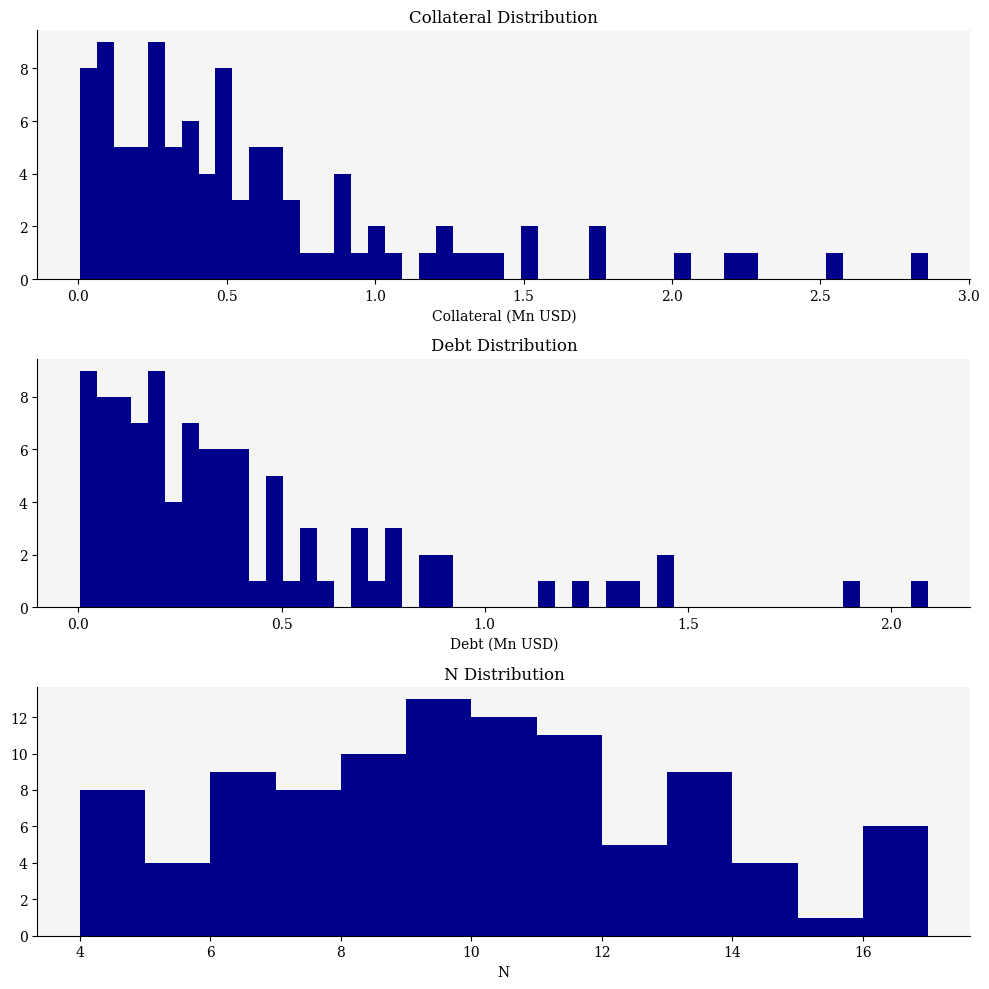

In [4]:
borrowers = controller.gen_borrowers(N_BORROWERS, COINS, v=True)
_plot_borrowers(borrowers, BASE_PRICE)

In [5]:
# Check that this generate func will generally give us ~
debts = []
for _ in range(1000):
    bs = controller.gen_borrowers(N_BORROWERS, COINS)
    debts.append(bs[:,1].sum())
print(f"Mean debt: {round(np.mean(debts) / 1e6)} Mns USD")
print(f"Desired debt: {DEBT / 1e6} Mns USD")

Mean debt: 39 Mns USD
Desired debt: 44.0 Mns USD


In [6]:
for i, b in enumerate(borrowers):
    # Deposit!
    controller.create_loan(i, *b)

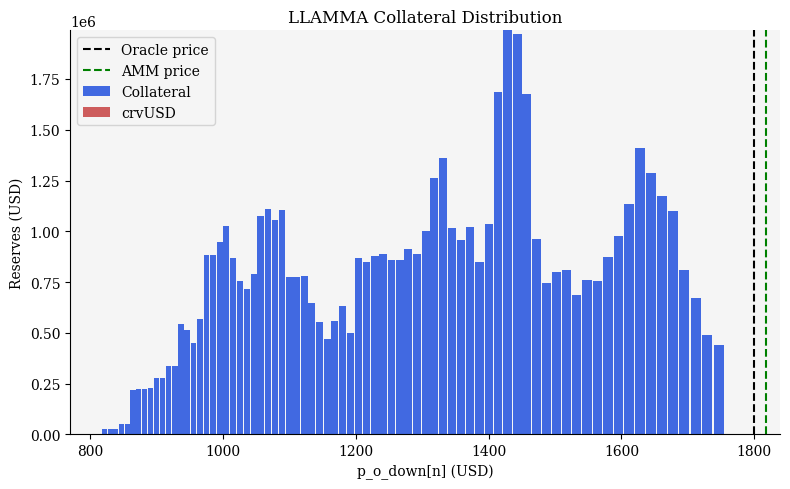

In [7]:
llamma.plot_reserves()

In [8]:
# NOTE run this to see that oracle updates affect llamma
# oracle.update(START + 60*60, BASE_PRICE * 0.9)
# llamma.plot_reserves()

Performed arbitrage, profit: 591702 USD


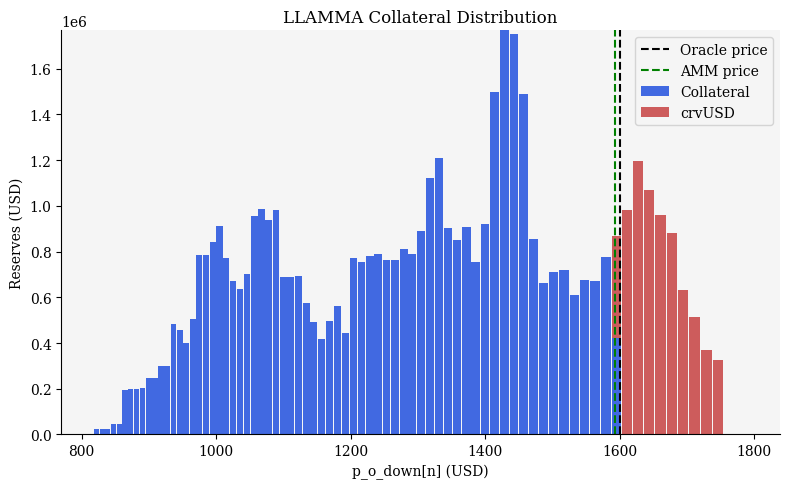

In [9]:
# NOTE if all fees are 0 and we there's very deep ext liquidity then arbitrageurs will equilibrate prices
# TODO incorporate this into a test!

p_mkt = 1600 # <- target price for arbitrage

ext_stable_liquidity = 2e10 # NOTE very high, ~ no slippage
ext_collat_liquidity = ext_stable_liquidity / p_mkt # <- external liquidity is at market price
ext_swap_fee = 0.005

llamma_cp = copy.deepcopy(llamma)
oracle_cp = copy.deepcopy(llamma.oracle)
llamma_cp.oracle = oracle_cp
oracle_cp.update(oracle_cp.last_timestamp + 60*1000, p_mkt) # <- update oracle to be close to market price

liquidator.arbitrage(llamma_cp, p_mkt, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
llamma_cp.plot_reserves()


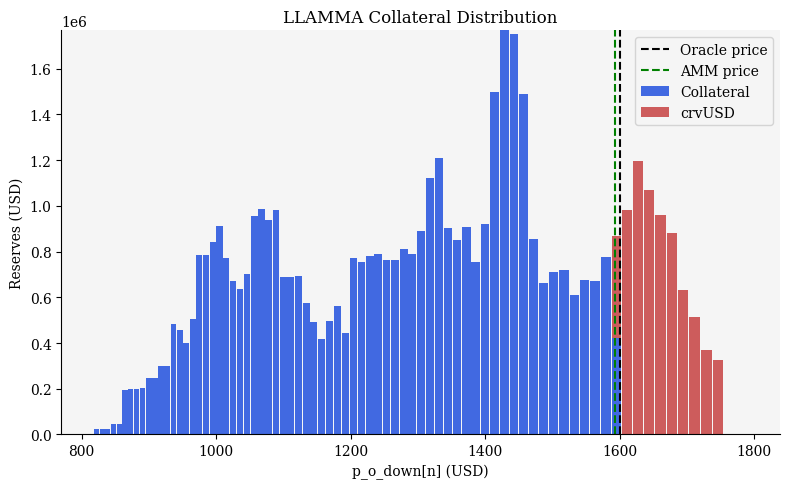

In [10]:
llamma_cp.plot_reserves()

In [11]:
sum(llamma_cp.bands_x.values())

7382356.691218179

In [12]:
# NOTE the problem is that when a band gets to 0 reserves the reported price is mid price and is not the target price
# Perhaps the problem is that you just can't get to a certain price! So if optimal p is not reachable

ps = [BASE_PRICE, 1750, 1700, 1775, 1600, 1650, 1500]

ext_stable_liquidity = 2e10 # NOTE very high, ~ no slippage
ext_collat_liquidity = ext_stable_liquidity / ps[0] # <- external liquidity is at market price
ext_swap_fee = 0.005

llamma_cp = copy.deepcopy(llamma)
oracle_cp = copy.deepcopy(llamma.oracle)
llamma_cp.oracle = oracle_cp

frame = 0
for p in ps:
    fn = f"./figs/test_{frame}.png"
    ext_collat_liquidity = ext_stable_liquidity / p # <- external liquidity is at market price
    oracle_cp.update(oracle_cp.last_timestamp + 60*1000, p) # <- update oracle to be close to market price
    liquidator.arbitrage(llamma_cp, p, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    llamma_cp.plot_reserves(fn)
    frame += 1

Performed arbitrage, profit: 1312 USD
Performed arbitrage, profit: 39817 USD
Performed arbitrage, profit: 79447 USD
Performed arbitrage, profit: 565647 USD
Performed arbitrage, profit: 62243 USD
Performed arbitrage, profit: 599769 USD


In [13]:
frames = [imageio.v2.imread(f"./figs/test_{i}.png") for i in range(len(ps))]
imageio.mimsave('./figs/test.gif', frames, fps=2)

(24, 4)


<Axes: xlabel='timestamp'>

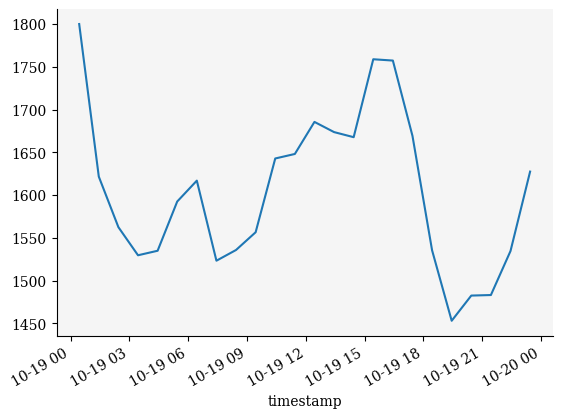

In [14]:
# Now let's create some dummy prices and assume that liquidators
# will liquidate when profitable.

PERIOD = 86400 # 1 day
WINDOW = 60*60
nobs = PERIOD//WINDOW

times = [START] + [int(START + dt*WINDOW) for dt in range(1, nobs)]

df = pd.DataFrame(columns=['timestamp', 'spot', 'oracle', 'liquidator_pnl'])
df['timestamp'] = times
df.index = pd.to_datetime(df['timestamp'], unit='s')
df['spot'] = np.concatenate([[BASE_PRICE], gen_gbm(S0=BASE_PRICE,mu=-0.1, sigma=0.2, dt=1/nobs,T=1)[1:]])
print(df.shape)
df['spot'].plot()

In [15]:
# Init external market liquidity for slippage calc
ext_stable_liquidity = 2e16 # NOTE why 2M?
ext_collat_liquidity = ext_stable_liquidity / BASE_PRICE
ext_swap_fee = 0.005

frame = 0
# Run simulation
for i, row in df.iterrows():
    fn = f"./figs/big_test_{frame}.png"
    print(i)
    
    # Update oracle
    ema_price = oracle.update(row['timestamp'], row['spot'])
    df.loc[i, 'oracle'] = ema_price

    # Update external liquidity
    ext_collat_liquidity = ext_stable_liquidity / row['spot']

    # Check for liquidations
    liquidator.perform_liquidations(controller, ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    
    # Check for arbitrage
    liquidator.arbitrage(llamma, row['spot'], ext_stable_liquidity, ext_collat_liquidity, ext_swap_fee)
    df.loc[i, 'liquidator_pnl'] = liquidator.pnl
    llamma.plot_reserves(fn)
    frame += 1

2023-10-19 00:26:21
2023-10-19 01:26:21
Liquidated user 15 with pnl 75450.06922154687.
Performed arbitrage, profit: 258740 USD
2023-10-19 02:26:21
Liquidated user 4 with pnl 1227.9823882138517.
Liquidated user 21 with pnl 46382.12388422503.
Liquidated user 32 with pnl 26360.113257429155.
Liquidated user 33 with pnl 4022.4819501584425.
Liquidated user 46 with pnl 24739.026402327465.
Missed liquidation for user 54 with health -0.07391405670544937.
Liquidated user 55 with pnl 3371.7358798841087.
Missed liquidation for user 79 with health -0.0867212209310988.
Missed liquidation for user 92 with health -0.09128378608931387.
Performed arbitrage, profit: 69320 USD
2023-10-19 03:26:21
Missed liquidation for user 54 with health -0.07391405670544571.
Missed liquidation for user 79 with health -0.08672122093109591.
Liquidated user 88 with pnl 10057.447142431156.
Liquidated user 91 with pnl 1705.7663451925418.
Missed liquidation for user 92 with health -0.09128378608931031.
Liquidated user 96 with

In [20]:
df.tail()

,timestamp,spot,oracle,liquidator_pnl
timestamp,,,,
2023-10-19 19:26:21,1697743581,1453.074787,1453.279819,3154929.239593
2023-10-19 20:26:21,1697747181,1482.522844,1482.450358,3180020.218411
2023-10-19 21:26:21,1697750781,1483.154359,1483.152614,3180084.596719
2023-10-19 22:26:21,1697754381,1534.584848,1534.45736,3532215.064699
2023-10-19 23:26:21,1697757981,1627.481610,1627.251026,3604579.717082


In [18]:
frames = [imageio.v2.imread(f"./figs/big_test_{i}.png") for i in range(len(df))]
imageio.mimsave('./figs/big_test.gif', frames, fps=3)